In [1]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using JLD2


cd(dirname(pwd()))
cd("src") 
includet("OneDOHP.jl")
using ..OneDOHP

┌ Warning: Error requiring `StaticArrays` from `ArrayInterface`
│   exception = (ErrorException("too many parameters for type"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000068f84117, Ptr{Nothing} @0x0000000068ff06a9, Ptr{Nothing} @0x000000006901236c, Ptr{Nothing} @0x0000000069012031, Ptr{Nothing} @0x0000000069012b40, Ptr{Nothing} @0x0000000069013515, Base.InterpreterIP in top-level CodeInfo for ArrayInterface at statement 82, Ptr{Nothing} @0x0000000069030c9d, Ptr{Nothing} @0x000000006903241a, Ptr{Nothing} @0x000000001a280bef, Ptr{Nothing} @0x000000001a280c13, Ptr{Nothing} @0x000000001a266531, Ptr{Nothing} @0x000000001a280b3a, Ptr{Nothing} @0x000000001a280b63, Ptr{Nothing} @0x000000001a265e98, Ptr{Nothing} @0x000000001a280aa1, Ptr{Nothing} @0x000000001a280ad3, Ptr{Nothing} @0x000000001a261a8e, Ptr{Nothing} @0x000000001a2689f4, Ptr{Nothing} @0x000000001a268d13, Ptr{Nothing} @0x0000000069030130, Ptr{Nothing} @0x0000000069026590, Ptr{Nothing} @0x000000001a1ca107, Ptr{No

In [2]:
using Plots
gr()  

Plots.GRBackend()

# Properies

### Earth property

In [3]:
g = 9.8

9.8

### Solid Physical parameters

In [4]:
ρₛ = 2700; # density
cₛ  = 8.97e02; # specific heat
kₛ  = 1.67e02; # heat conductivity
# d = 2e-3;
plate_d = 2e-3;  # plate thickness
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2700.0, 897.0, 167.0, 6.895412692514142e-5, 0.002)

### Fluid Physical parameters

In [5]:
fluid_type = "butane"
Tᵥ = 295.0

295.0

In [6]:
Cpₗ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",0.0,fluid_type)
ρₗ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",0.0,fluid_type)
μₗ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",0.0,fluid_type)
hₗ = CoolProp.PropsSI("H","T",Tᵥ,"Q",0.0,fluid_type)
kₗ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",0.0,fluid_type)
Prₗ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",0.0,fluid_type)

Cpᵥ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",1.0,fluid_type)
ρᵥ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",1.0,fluid_type)
μᵥ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",1.0,fluid_type);
hᵥ = CoolProp.PropsSI("H","T",Tᵥ,"Q",1.0,fluid_type)
kᵥ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",1.0,fluid_type)
Prᵥ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",1.0,fluid_type)

σ = CoolProp.PropsSI("I","T",Tᵥ,"Q",0.0,fluid_type)
P = CoolProp.PropsSI("P","T",Tᵥ,"Q",0.0,fluid_type)
R = CoolProp.PropsSI("GAS_CONSTANT","T",Tᵥ,"Q",1.0,fluid_type)
M = CoolProp.PropsSI("M","T",Tᵥ,"Q",1.0,fluid_type)
Rkg = R/M

αₗ = kₗ/ρₗ/Cpₗ
νₗ = μₗ/ρₗ
νᵥ = μᵥ/ρᵥ;
hₗᵥ = hᵥ-hₗ;

# Plate Conduction

### Geometry parameters

In [7]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [8]:
xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


(0.0005516330154011314, 0.001323919236962715)

### Set up the evaporator and condenser

In [9]:
inch = 2.54e-2;

In [10]:
power = 40 *0 #watts
total_heater_area = 2.0inch*2.0inch;

In [11]:
qe = power/total_heater_area
hc = 1500.0 * 0
Tc = Tᵥ

295.0

In [12]:
eb1 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((0.7inch,-0.0),0.0)
Tfe(eb1)

eb2 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((-0.7inch,-0.0),0.0)
Tfe(eb2)

cb1 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((-2.5inch,-0.0),0.0)
Tfc(cb1)

cb2 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((2.5inch,-0.0),0.0)
Tfc(cb2)

eparams1 = PrescribedHeatFluxRegion(qe,eb1);
eparams2 = PrescribedHeatFluxRegion(qe,eb2);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

In [13]:
ds = 1.5Δx
nturn = 16
width_ohp = 46.25*1e-3
length_ohp = 133.83*1e-3
gap = plate_d
pitch = width_ohp/(2*nturn+1)
x0, y0 = length_ohp/2, width_ohp/2

# x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,length_ohp,gap,ds,x0,y0,false,false,3pi/2)
one_loop_gap = 1e-2
x, y, xf, yf = construct_oneloop_curve(0,0,ds,length_ohp,one_loop_gap,pi/2)


ohp = BasicBody(x,y)

Basic pointwise-specified body with 362 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


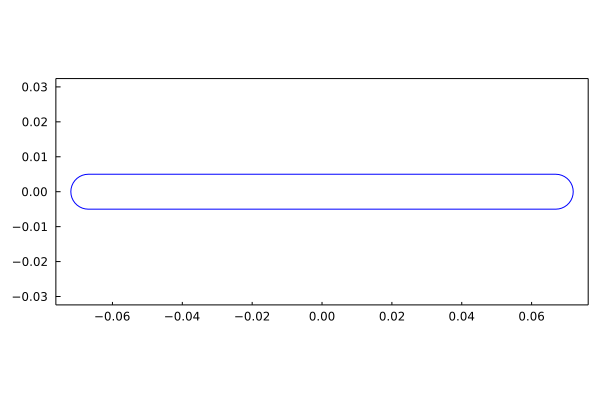

In [14]:
plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)

In [15]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)

LineSourceParams{BasicBody{362,RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 362 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

### Create the system

In [16]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom,qflux=[eparams1,eparams2],qmodel=[cparams1,cparams2])

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


# OHP inner part

### Tube geometries

In [17]:
tube_d = 1e-3; # tube diameter
peri = 4*tube_d # Tube perimeter
Ac = tube_d*tube_d # tube cross-sectional area
L2D = length_ohp # the actual length of the bended pipe in the real world
L = (sys.qline[1].arccoord[1] + sys.qline[1].arccoord[end])  # total length of the pipe when streched to a 1D pipe (an approximate here)
angle = 0*pi/2 # inclination angle 
closedornot = true

true

In [18]:
tube = Tube(tube_d,peri,Ac,L,L2D,angle,g,closedornot);

### Liquid

In [19]:
Nu = 1e-10
Hₗ = kₗ/tube_d * Nu # Nusselt number 4.36

1.0602468282359685e-8

In [20]:
# X0,realratio = randomXp(L,numofslugs=60,chargeratio=0.45)
X0 = [(L2D*1/4,L2D*3/4),(L2D*1/4 + L/2,L2D*3/4 + L/2)]

dXdt0_l = zeros(length(X0)) .+ 1.0
dXdt0_r = zeros(length(X0)) .+ 1.0
dXdt0 = map(tuple,dXdt0_l,dXdt0_r)

2-element Array{Tuple{Float64,Float64},1}:
 (1.0, 1.0)
 (1.0, 1.0)

In [21]:
X0

2-element Array{Tuple{Float64,Float64},1}:
 (0.0334575, 0.1003725)
 (0.18312696308817156, 0.25004196308817156)

In [22]:
# construct liquids
N=numpts(ohp)
Xarrays,θarrays = constructXarrays(X0,N,Tᵥ,L);

In [23]:
liquids=Liquid(Hₗ,ρₗ,Cpₗ,αₗ,μₗ,X0,dXdt0,Xarrays,θarrays);

### Vapor

In [24]:
P = 0*zeros(length(X0)) .+ TtoP(Tᵥ);
P[2] = P[1] + 1000;
δ = 0*zeros(length(X0)) .+ 99999;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
vapors=Vapor(kₗ,P,δ);

### Wall

nucleate boiling sites

In [25]:
ΔTthres = 100.0; # superheat threshold
# ΔTthres = 1.0; # superheat threshold

    nucleatenum = 256
    Xstations = sort(rand(nucleatenum).*L);
#     Xstations = LinRange(0.0,L-L/nucleatenum,nucleatenum)
#     boilingΔt = 0.05

In [26]:
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,Tᵥ);
θwallarray .= Tᵥ

wall = Wall(ΔTthres,Xstations,Xwallarray,θwallarray);

In [27]:
sys0_nomapping = PHPSystem_nomapping(tube,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [28]:
sys0 = PHPSystem(tube,liquids,vapors,wall,mapping);

### construct state vector U

In [29]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = PtoD(P) .* Lvaporplug .* Ac
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [30]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

# combine inner tube and plate together

In [31]:
tspan = (0.0, 1e-7);
dt_record = tspan[2] /10;

tstep=1e-8

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [32]:
ΔT = 1.0 #[K]

1.0

In [33]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
# Tplate = temperature(integrator_plate);
temperature(integrator_plate) .= Tᵥ + ΔT;

In [50]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, dt=tstep, callback=cbst);

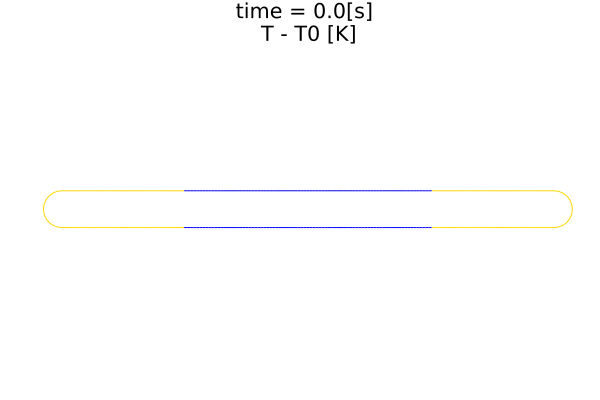

In [51]:
    Htmp = sys_to_Harray(getcurrentsys(integrator_tube.u,integrator_tube.p))
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",title=string("time = ", 0.0 , "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)

In [52]:
plate_hist = []
tube_hist  = []

currentsys = integrator_tube.p
currentsys = getcurrentsys(integrator_tube.u,currentsys);

currentsys.wall.θarray = temperature_linesource(integrator_plate)
currentsys = getcurrentsys(integrator_tube.u,currentsys)
integrator_tube.p = currentsys
qtmp = sys_to_heatflux(currentsys)
set_linesource_strength!(sys,qtmp);

In [53]:
push!(plate_hist,deepcopy(integrator_plate)); 
push!(tube_hist,deepcopy(integrator_tube));

In [54]:

@time for t in tspan[1]:tstep:tspan[2]
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t-tstep,integrator_plate.t), currentsys)
    integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep);
    step!(integrator_tube,tstep,true);
    
    
      for j in 1:N_iter
        currentsys.wall.θarray = temperature_linesource(integrator_plate)
        currentsys = getcurrentsys(integrator_tube.u,currentsys)

        qtmp = sys_to_heatflux(currentsys)
        set_linesource_strength!(sys,qtmp)


#      ADI_timemarching!(temperature(integrator_plate),sys,tstep)
    end
    integrator_plate.t += tstep
    

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

1.2e-7
1.3e-7
1.4e-7
1.5000000000000002e-7
1.6000000000000003e-7
1.7000000000000004e-7
1.8000000000000005e-7
1.9000000000000006e-7
2.0000000000000007e-7
2.1000000000000008e-7
2.200000000000001e-7
  2.407316 seconds (3.35 M allocations: 421.854 MiB, 20.29% gc time)


In [55]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

## Plot the animation

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
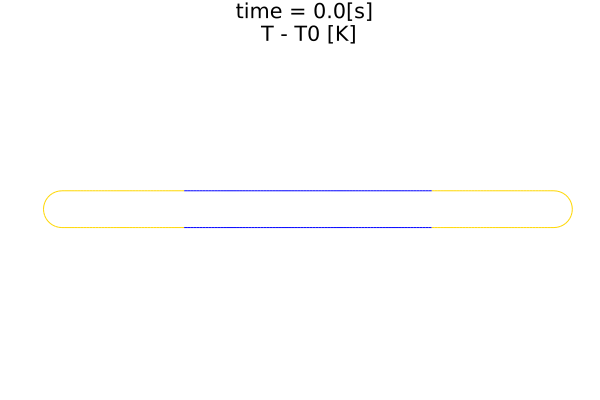

In [56]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)
end

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
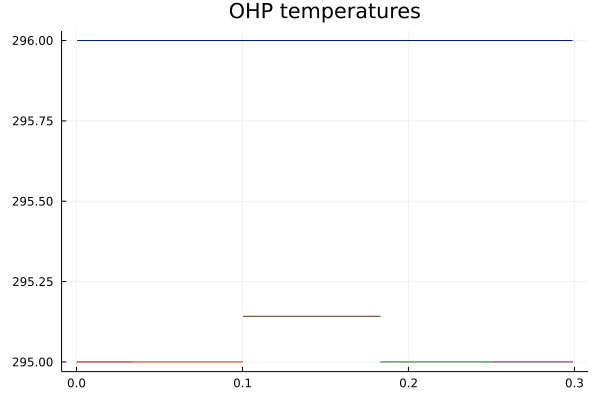

In [57]:
@gif for ii=1:length(sysfinal)
     plot(sysfinal[ii],plottype="T")
end

In [104]:
Xp1_hist = []
Xp2_hist = []
t_hist = []
for i=1:length(sysfinal)
    Xp1=deepcopy(sysfinal[i].liquid.Xp[1][1]);
    Xp2=deepcopy(sysfinal[i].liquid.Xp[2][1]);
    push!(Xp1_hist, Xp1)
    push!(Xp2_hist, Xp2)
    push!(t_hist, plate_hist[i].t)
end


In [105]:
plot(t_hist,Xp1_hist);

In [106]:
Vp1_hist = zeros(length(Xp1_hist)-1)
for i = 1:length(Vp1_hist)
    Vp1_hist[i] = (Xp1_hist[i+1]-Xp1_hist[i])/tstep
end

Vp2_hist = zeros(length(Xp2_hist)-1)
for i = 1:length(Vp2_hist)
    Vp2_hist[i] = (Xp2_hist[i+1]-Xp2_hist[i])/tstep
end

In [107]:
plot(t_hist[1:end-1],Vp1_hist);

In [108]:
a1 =(Vp1_hist[end]-Vp1_hist[1])/(t_hist[end-1]-t_hist[1])
a2 =(Vp2_hist[end]-Vp2_hist[1])/(t_hist[end-1]-t_hist[1])
# a * ρₗ*Ac .* Lliquidslug[1]

16.847634398686733

### Compare with analytical result at the beginning

In [109]:
Lliquidslug = XptoLliquidslug(sys0.liquid.Xp,sys0.tube.L)

2-element Array{Float64,1}:
 0.066915
 0.066915

In [110]:
Lvaporslug = XptoLvaporplug(sys0.liquid.Xp,sys0.tube.L,closedornot)

2-element Array{Float64,1}:
 0.08275446308817155
 0.08275446308817155

In [90]:
Hᵥ=kₗ/δ[1]

1.0602574308102766e-6

In [91]:
ΔT * (Hᵥ * peri * Lvaporslug[1] + Hₗ * peri * Lliquidslug[1])

3.538019943482509e-10

In [92]:
L_test = X0[1][2]-X0[1][1]

0.066915

In [93]:
dXdt0[1][1]

1.0

In [94]:
F1 = 8*μₗ/tube_d*dXdt0[1][1] * peri * L_test

0.00034951571322190515

In [95]:
F2 = (P[2]-P[1])*Ac

0.001

In [96]:
lhs = ρₗ*Ac .* Lliquidslug

2-element Array{Float64,1}:
 3.857467571158984e-5
 3.857467571158984e-5

In [97]:
(F1 - F2) / lhs[1]

-16.862987822413647

### to confirm we get the right acceleration given initial velocity and pressure difference (ignoring gravity for now)

\begin{equation}
    A_{\mathrm{c}} L_{\mathrm{p},i} \rho_{\mathrm{p}} \frac{\mathrm{d}^{2} z_{\mathrm{p},2i-1} }{\mathrm{~d} t^{2}}=\left(p_{\mathrm{v},i}-p_{\mathrm{v},i+1}\right) A_{\mathrm{c}}-P_c L_{\mathrm{p},i} \tau_{\mathrm{p},i}.
    \label{eq:momentum}
\end{equation}



\begin{equation}
\tau_{\mathrm{p},i}=\mu_\mathrm{p}  \frac{\partial u_{\mathrm{wall},i}}{\partial z}=8 \frac{\mu_\mathrm{p}}{d} \frac{\mathrm{d} z_{\mathrm{p},2i-1}}{\mathrm{d} t} ,
\end{equation}

Δp = 1000 [Pa]

 $\frac{\mathrm{d} z_{\mathrm{p},2i-1}}{\mathrm{d} t}_{initial} = 1 [m/s]$

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
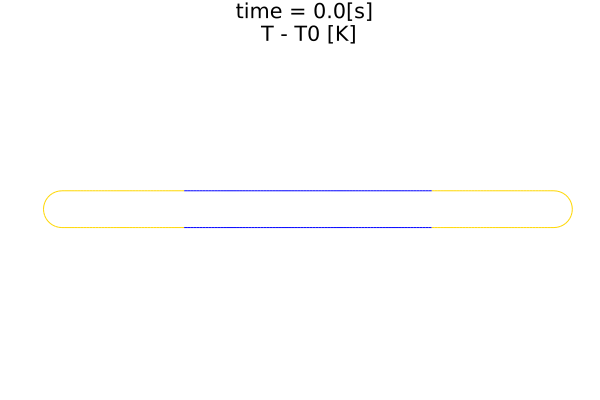

In [103]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)
end

In [115]:
a1 

-34.98590306350021

In [116]:
-(F1 + F2) / lhs[1]

-34.98449924276202

In [117]:
a2

16.847634398686733

In [118]:
-(F1 - F2) / lhs[1]

16.862987822413647